In [1]:
import pandas as pd
import numpy as np
import shapely
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import geopandas as gpd
import glob
import os
import seaborn as sns
import copy
from sklearn.model_selection import train_test_split
from itertools import permutations, combinations

from bayesianRidge import *
from bayesian_network import *

# Acquire paths and cellid
paths = glob.glob('../data/Chosen_grids_data_add_class/*.csv')
cellId = [os.path.splitext(os.path.basename(path))[0] for path in paths]

In [2]:
dfs = [pd.read_csv(path,parse_dates=['date']) for path in paths]

In [3]:
dfs[0].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 720 entries, 0 to 719
Data columns (total 10 columns):
date                720 non-null datetime64[ns]
dayofweek           720 non-null int64
hour                720 non-null int64
current             720 non-null float64
avg_current         720 non-null float64
threshold           720 non-null float64
current_class       720 non-null int64
temperature         720 non-null float64
temperature_diff    720 non-null float64
precipitation       720 non-null float64
dtypes: datetime64[ns](1), float64(6), int64(3)
memory usage: 56.3 KB


In [4]:
cellId

['3215', '5111', '5202', '2972', '5550']

In [5]:
edges = [('3215','5550'),('5202','2972'),('2972','5550'),('5550','5111')]

In [6]:
dfs[0].head()

,date,dayofweek,hour,current,avg_current,threshold,current_class,temperature,temperature_diff,precipitation
0,2013-11-01,4,0,-4.231813,74.981546,2.324921,0,9.6,4.4,0.0
1,2013-11-01,4,1,-1.574762,74.901375,0.314953,0,9.6,4.4,0.0
2,2013-11-01,4,2,-0.784519,72.364578,0.332132,0,9.6,4.4,0.0
3,2013-11-01,4,3,0.601272,69.976667,0.601272,0,9.6,4.4,0.0
4,2013-11-01,4,4,-1.494592,68.665321,0.481017,0,9.6,4.4,0.0


Index(['date', 'dayofweek', 'hour', 'current', 'avg_current', 'threshold',
       'current_class', 'temperature', 'temperature_diff', 'precipitation'],
      dtype='object')


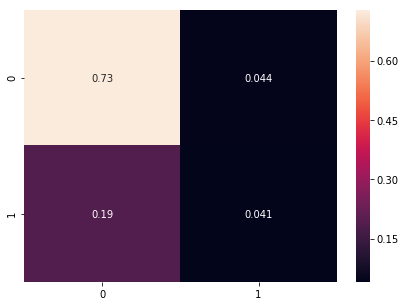

defaultdict(int, {(0, 0): 2096, (0, 1): 128, (1, 0): 539, (1, 1): 117})

In [18]:
from itertools import permutations
from collections import defaultdict

def Generate_train_test(dfs, test_size=0.2, random_state=15):
    # Given a list of dfs, and return train dfs and test dfs
    # They contain samples with same indexes.
    
    train_dfs, test_dfs = [], []
    
    for df in dfs:
        train_df, test_df = train_test_split(df,test_size=test_size,random_state=random_state)
        train_dfs.append(train_df)
        test_dfs.append(test_df)
    
    return train_dfs, test_dfs


def Fit(cellId, edges, dfs):
    # Learn the br and bn models separately, edges determine the structure of the graph
    
    # Learn the bayesian regression models for each cell
    br_model = BR(cellId, dfs)
    print(br_model.labels)
    # Set parameters and target
    params = ['temperature', 'temperature_diff', 'precipitation']
    target = 'current'
    br_model.fit(params, target)
    
    # Learn the bayesian network models for current network structure
    # Using cellId and edges
    bn_model = bayesian_network(cellId, edges)
    
    # Load current data into a dictionary
    currnet_class_data = {id_: df for id_, df in zip(cellId, dfs)}
    
    bn_model.fit(currnet_class_data)
    
    return br_model, bn_model

def Inference(br_model, bn_model, cellId, dfs):
    # bg_model is the linear bayesian regression model,
    # bn_model is the bayesian network model
    # obs are the observatiosn in certain cell ids 
    # - time, temperature, temperature_diff, precipitation
    
    samples_nums = dfs[0].shape[0]
    
    # Results counts 4 terms, including
    # (truth 0, predict 0), (truth 0, predict 1), (truth 1, predict 0), (truth 1, predict 1)
    results = defaultdict(int)
    
    probs = br_model.predict(cellId, dfs) # acquire the prob for each cellId
    
    for i in range(samples_nums):
        
        # Select certain idx, do Inference for each combination of two networks
        new_dfs = [df.iloc[i,:] for df in dfs]
        
        class_probs = [prob[i] for prob in probs]
        
        for (start, end) in permutations(cellId, 2):
            
            # Find the index of cellid in cellId
            start_idx, end_idx = cellId.index(start), cellId.index(end)
            
            # Predict current class using weather conditions
            
            # Soft assign
#             start_prob = class_probs[start_idx]
            
            # Hard assign
            start_class = np.argmax(class_probs[start_idx])
            start_prob = np.zeros((2,))
            start_prob[start_class] = 1
            
            end_prob = bn_model.predict(start, end, start_prob)
            
            # Compare the results with grond truth
            pd_class = np.argmax(end_prob)
            gt_class = new_dfs[end_idx]['current_class']
            
            # count results
            results[(gt_class,pd_class)] += 1

    return results

def Vasualize_results(results):
    
    probs = np.zeros((2,2))
    for key, val in results.items(): probs[key] = val
    probs = probs / np.sum(probs)
    
    plt.figure(figsize=(7,5))
    sns.heatmap(probs,
                annot=True,
                xticklabels=[0, 1],
                yticklabels=[0, 1])
    plt.show()

def Main(cellId, edges, dfs):
    
    # Split train and test dfs
    train_dfs, test_dfs = Generate_train_test(dfs)
    
    # Train the bayesian regression and bayesian network model
    br_model, bn_model = Fit(cellId, edges, train_dfs)
    
    # Inference and statistical results
    results = Inference(br_model, bn_model, cellId, test_dfs)
    
    Vasualize_results(results)
    
    return results

Main(cellId, edges, dfs)